# Notebook para análisis especial Música Clásica

Con el problema de la pandemia y la cuarentena muchos músicos clásicos perdieron sus fuentes de ingresos al suspenderse los conciertos. El problema se agrava si se tiene en cuenta que este rubro musical no atrae a tanta gente hoy en día.
Con esta notebook haremos un análisis rápido de los datos que tiene Spotify sobre la música clásica, para obtener las piezas interpretables más populares. Así pueden ser incluídas en las performances para atraer más público.

In [52]:
import spotipy #pip install spotipy --upgrade
from spotipy.oauth2 import SpotifyClientCredentials#para gestionar la autenticacion contra la API de Spotify
import pandas as pd
import numpy as np


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Inicializamos Spotipy

##### Credenciales para conectarse a la web api de Spotify

In [2]:
SPOTIPY_CLIENT_ID = 'e8b2379bdd054eb993035179ae40e066'
SPOTIPY_CLIENT_SECRET = 'f191a3a661cc47d68b92a296669dde05'#este valor puede ser cambiado desde la app

##### Incializamos el objeto sp para poder realizar las requests

In [3]:
client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager= client_credentials_manager)

# Realizamos las consultas filtrando por música clásica

In [39]:
artistas=['Johann Sebastian Bach','Wolfgang Amadeus Mozart','Frédéric Chopin','Ludwig van Beethoven','Claude Debussy',
          'Antonio Vivaldi','Pyotr Ilyich Tchaikovsky','Herbert von Karajan','Erik Satie','Franz Schubert',
          'Camille Saint-Saëns','Edvard Grieg','Johannes Brahms','George Frideric Handel','Franz Liszt','Sergei Rachmaninoff',
          'Antonín Dvořák','Franz Joseph Haydn','Robert Schumann','Felix Mendelssohn','Edward Elgar','Sergei Prokofiev',
          'Dmitri Shostakovich','Johann Pachelbel','Jean Sibelius','Igor Stravinsky','Gustav Mahler','Richard Wagner',
          'Richard Strauss']

##### Seteamos la cantidad de máxima de tracks que queremos tomar como muestra

In [41]:
max_cantidad_tracks_por_artista = 500

##### Seteamos un offset inicial para comenzar a tomar desde ahí los tracks

In [42]:
initial_offset = 0

##### Realizamos la consulta

In [43]:
#declaramos un array de diccionarios donde vamos a ir poniendo los resultados, para luego generar el data frame
data = []


#loopeamos por artista
for artista in artistas:
    print('Artista: ' + artista)   
    
    #configuramos la consulta para el año actual
    search_query = 'artist:' + artista

    #incializamos un contador de tracks, para no traer mas de las que configuramos en max_cantidad_tracks
    tracks_obtenidas = 0        

    #definimos una cantidad maxima de reintentos ante errores
    max_retry = 3

    #la web api solo permite obtener hasta 50 items a la vez, es por eso que para llegar a cantidad max de tracks
    #por año, se deberá realizar más de una consulta para el mismo año
    while tracks_obtenidas < max_cantidad_tracks_por_artista:                

        #si ya no quedan reintentos, se abandona el año
        if(max_retry<=0):
            print('\nSe consumieron todos los reintentos, se abandona el proceso.')
            break

        try:
            #cuando se hace una consulta a la web api, spotify encuentra por ejemplo 120 resultados
            #pero solo permite traer de a 50 (limit) a la vez, para poder traer todos hay que ir moviéndose en ese
            #resultado con el offset. Para traer las primeras 50, el offset = 0, para traer las siguientes 50, el offset = 50
            result = sp.search(search_query, limit=50, offset=initial_offset+tracks_obtenidas, type='track', market='AR')

            if(result is not None and result['tracks'] is not None and len(result['tracks']['items']) > 0):
                #nos quedamos con las tracks
                tracks_results = list(result['tracks']['items'])

                #por cada uno de los tracks obtenidos, consultamos los datos tecnicos
                #y luego generamos una entrada en el array de diccionarios
                for track_result in tracks_results:
                    track_spotify_id = track_result['id']

                    #nos aseguramos de no agregar mas tracks que las que se establecieron en max_cantidad_tracks
                    if(tracks_obtenidas < max_cantidad_tracks_por_artista):
                        #agregamos los datos al array de diccionarios
                        data.append({'popularity': track_result['popularity'], 'id':track_spotify_id, 
                                     'name':track_result['name'],
                                     'artista' : artista
                                    })

                        tracks_obtenidas += 1
                        print(str(tracks_obtenidas) + ' tracks obtenidas!', end='\r')


            else:
                print('Datos vacíos, reintentando')
                #ante cualquier error, bajamos la cantidad de reintentos y seguimos
                max_retry -= 1                    

        except Exception as e: 
            print('Error: '+ str(e))
            print('Reintentando')
            #ante cualquier error, bajamos la cantidad de reintentos y seguimos
            max_retry -=1



Artista: Johann Sebastian Bach
Artista: Wolfgang Amadeus Mozart
Artista: Frédéric Chopin
Artista: Ludwig van Beethoven
Artista: Claude Debussy
Artista: Antonio Vivaldi
Artista: Pyotr Ilyich Tchaikovsky
Artista: Herbert von Karajan
Artista: Erik Saties!
Artista: Franz Schubert
Artista: Camille Saint-Saëns
Artista: Edvard Grieg
Artista: Johannes Brahms
Artista: George Frideric Handel
Artista: Franz Liszt!
Artista: Sergei Rachmaninoff
Artista: Antonín Dvořák
Artista: Franz Joseph Haydn
Artista: Robert Schumann
Artista: Felix Mendelssohn
Artista: Edward Elgar
Artista: Sergei Prokofiev
Artista: Dmitri Shostakovich
Artista: Johann Pachelbel
Artista: Jean Sibelius
Artista: Igor Stravinsky
Artista: Gustav Mahler
Artista: Richard Wagner
Artista: Richard Strauss


# Generamos el DataFrame

In [44]:
df_tracks = pd.DataFrame(data)

In [48]:
df_tracks = df_tracks.drop_duplicates(subset=['name','artista'],keep='last')

In [58]:
top = df_tracks.sort_values('popularity', ascending=False).head(10)

In [64]:
top['tema_artista'] = top['name'] + ' - ' + top['artista']

In [65]:
#df_tracks.to_csv('classical_tracks.csv',index=False,encoding='utf-8')

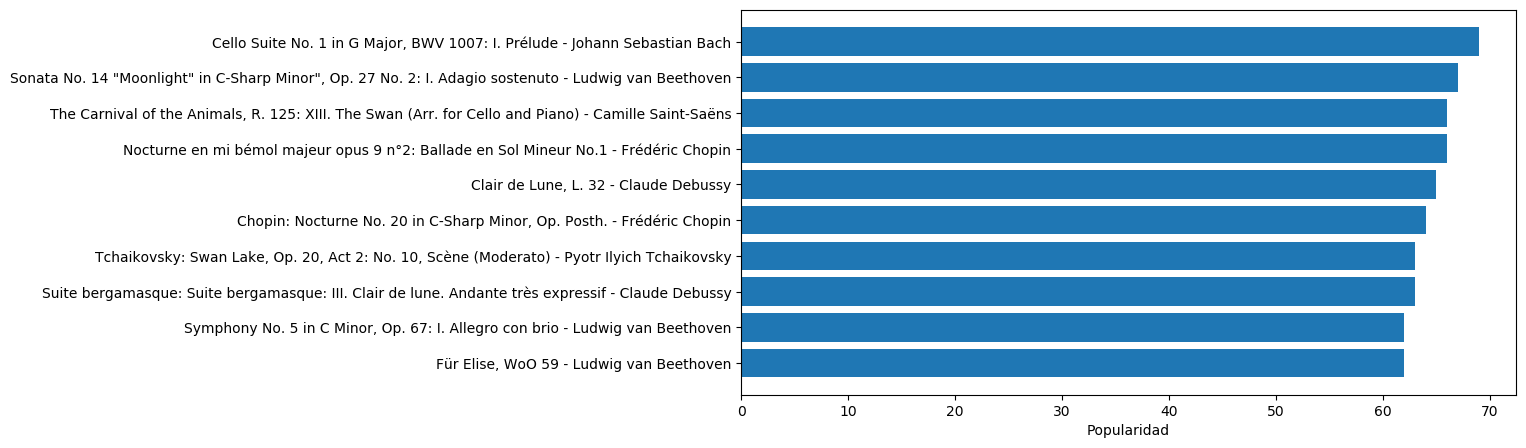

In [67]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10,5))

ax.barh(top['tema_artista'], top['popularity'], align='center')
ax.set_yticks(top['tema_artista'])
ax.set_yticklabels(top['tema_artista'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Popularidad')


plt.show()

In [68]:
agrupado_por_artista = df_tracks.groupby(by='artista')

In [83]:
agrupado_por_artista.mean()

,popularity
artista,
Antonio Vivaldi,5.674487
Antonín Dvořák,15.191436
Camille Saint-Saëns,16.315534
Claude Debussy,20.463636
Dmitri Shostakovich,12.941176
Edvard Grieg,17.697222
Edward Elgar,13.672973
Erik Satie,22.686111
Felix Mendelssohn,15.547215


##### Ordenamos por popularidad descendente, tomamos los primeros 20

In [ ]:
#df_tracks = pd.read_csv('classical_tracks.csv')

In [ ]:
df_tracks.sort_values('popularity', ascending=False).head(20)